# Lab 3: Due Friday 11/08 at 11:59pm

**Please Enter Your Name Here (if you worked with a partner enter their name too):**

## Submission Instructions:
Please submit one zip file containing *both* your ipynb notebook file and an exported html version of the notebook that shows all your answers. Assignments that are not submitted in this format will be returned with a grade of zero. 

To export a copy of your notebook in html either:
1. In VSCode, click the three dots "..." at the end of the commands at the top of the notebook and select "export -> html".
   - If this fails, you will need to either install Python along with the Python Jupyter and nbconvert packages, or use the next method.
2. Export the notebook using the Julia IJulia notebook interface instead of VSCode.
   
To setup and use the IJulia interface, in the REPL install the IJulia package:
```julia
using Pkg
Pkg.add("IJulia")
```
This may ask you to install some Python libraries via a yes/no question, just say yes.

Next start IJulia from within the REPL:
```julia
using IJulia
notebook()
```
This will open a file browser within your web browser. Navigate and open your notebook file now:
1. If no Julia kernel is showing at the top right of the screen, select "Kernel -> Change Kernel" and select the appropriate Julia kernel. 
2. Rerun all your code in notebook to ensure all your output is present. 
3. Finally, you can use "File -> Download As -> html" to download an html version of the notebook.

# Lab 3: The Inverse Transform Sampling Method and the Stochastic $\textrm{A} \to \varnothing$ Reaction

In this lab we'll investigate the inverse transform method and the stochastic chemical kinetics model for $\textrm{A} \to \varnothing$ at rate $\delta$. 

First, let's install a zero finding package we will make use of in the inverse transform method, and a special functions package that provides the `erf` function:

In [15]:
# only run this one time ever, then they should be installed!
# using Pkg
# Pkg.add("Roots")
# Pkg.add("SpecialFunctions")
# Pkg.add("Distributions")

## Inverse Transform Sampling:
The code below generates 1000 samples from an exponential distribution using inverse transform sampling. It then plots a normalized histogram of the samples along with the exact probability density function to show that inverse transform sampling actually works. Read through the code and make sure you understand what it is doing. Try running it for different numbers of samples to see how many you need before you can actually make out the underlying pdf from the histogram. Note, the method below uses bisection to invert the CDF. For the exponential distribution we showed in class how to explicitly invert the CDF, so this isn't really necessary, however, we will shortly look at a CDF we can't analytically invert.

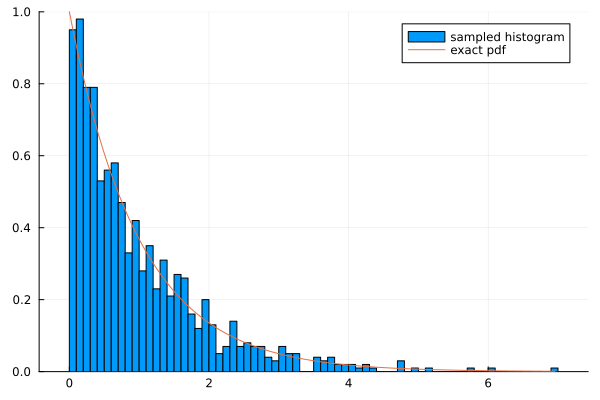

In [18]:
using Roots, Plots

# this code uses inverse sampling to sample a random variable, T
N = 1000                   # number of samples to generate

# exponential CDF with parameter μ=1
cdf   = t -> 1 - exp(-t)   # cumulative distribution function
pdf   = t -> exp(-t)       # probability density function
tmin  = 0.                 # smallest value t can take
tmax  = Inf                # t can go up to infinty

Tsamp = zeros(N)           # vector of sampled values

for i = 1:N
    r      = rand()
    fToMin = t -> cdf.(t) .- r   # zero when cdf(t) = r

    # we solve cdf(t) - r = 0 for t, using the bisection method.
    # we use the default tolerances of the solver as they are quite small
    Tsamp[i] = find_zero(fToMin, (tmin, tmax))  
end

# histogram with 100 equally space bins of the sampled times (normalized to compare with pdf):
p = histogram(Tsamp, bins=100, normalize=true, label="sampled histogram")

# plot pdf(t) for comparison
t = (0:100)/100 * maximum(Tsamp)
plot!(p, t, pdf.(t), label="exact pdf")

## Problem 1
Now change the cdf and pdf in the code to that for a Gaussian distribution with mean $\mu = 0$ and variance $\sigma^{2} = 1$.  The formulas are

$$
\begin{align*}
 \operatorname{pdf} &= \frac{1}{\sigma \sqrt{2 \pi}} e^{-(t - \mu)^{2} / 2 \sigma^{2}} \\
 \operatorname{cdf} &= \frac{1}{2} \left[ 1 + \operatorname{erf} \left( \frac{t - \mu}{\sqrt{2 \sigma^{2}}} \right) \right].
\end{align*}
$$

Also set `tmin = -Inf` since Gaussian random variables are defined on $(-\infty,\infty)$. Put your modified code in the cell below, and then run it to see if you still get the correct histogram for 10000 samples. Try varying $\mu$ and $\sigma$ and see what happens to the histogram. Note, in Julia the command `erf(x)` from the `SpecialFunctions` package will evaluate the error function.


In [20]:
# put your Gaussian sampling code here

# so we can use erf(x)
using SpecialFunctions

# this code uses inverse sampling to sample a random variable, T
N = 10000
μ = 0
σ = 1

# MODIFY HERE: code to sample Gaussian with mean μ=0 and variance σ²=1

# MODIFY HERE: make a histogram with 100 equally space bins of the sampled times (normalized to compare with pdf):
p = histogram(...)

# this will plot pdf(t) for comparison
t = (0:100)/100 * (maximum(Tsamp)-minimum(Tsamp)) .+ minimum(Tsamp)
plot!(p, t, pdf.(t), label="exact pdf")

Base.Meta.ParseError: ParseError:
# Error @ d:\Math\PhD\1st_year\second_sem\stochastic_mod_sim\practice_julia\stos_simulating\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X12sZmlsZQ==.jl:14:15
# MODIFY HERE: make a histogram with 100 equally space bins of the sampled times (normalized to compare with pdf):
p = histogram(...)
#             └─┘ ── invalid identifier

## Problem 2
Now replace the inverse sampling code for generating Gaussian random numbers with Julia's built-in Gaussian random number routine, `randn`. Look at its documentation at https://docs.julialang.org/en/v1/stdlib/Random/#Base.randn to see what mean and variance the random samples it generates have. Make sure your final code generates a similar histogram to the inverse sampling code you wrote above.

In [5]:
# put your randn based code here

## Simulating the Stochastic $\mathrm{A} \to \varnothing$ Reaction
The code below simulates the stochastic $\textrm{A} \to \varnothing$ reaction we studied in class. It generates `Nsims` simulations of the stochastic process and then plots each simulation (using the `linetype=:steppost` option to `plot`). It also plots the exact mean of $A(t)$ as the black curve, and $+/-$ one standard deviation about the mean as the dashed black curve (we will derive these formulas next week). Note that the exact mean of $A(t)$ is just the solution to the corresponding ODE model, $A_0 \exp(-\delta t)$. Run the code for `Nsims = 5` and then read through the code to make sure you understand what is going on. Now try running the code for `Nsims = 100`. 

First we give a routine to run one simulation and return the vector of $A$ values and the vector of reaction times:

In [6]:
using Random

#=
    Simulates one A->0 reaction trajectory. 
    
    Parameters
    ----------
    A₀ : scalar
        Initial value of A(t), i.e. A(0) = A₀
    
    δ  : scalar
        Rate at which molecules degrade. Units of per time.
    
    Returns
    -------
    (A,T) : tuple of two arrays.
        A = array of values of A after the reaction times in T
        T = array of times that reactions occur
=#
function generateTraject(A₀, δ)
    A    = zeros(A₀ + 1)
    T    = zeros(A₀ + 1)
    A[1] = A₀                 # initially have A0 molecules
    
    # run one simulation
    for i = 1:A₀        
        # sample time of next reaction
        T[i+1] = T[i] + randexp() / (δ * A[i])

        # execute reaction
        A[i+1] = A[i] - 1    # decrease A by one at reaction time                            
    end
    return A,T
end

generateTraject (generic function with 1 method)

Now we define our parameters and run several simulations:

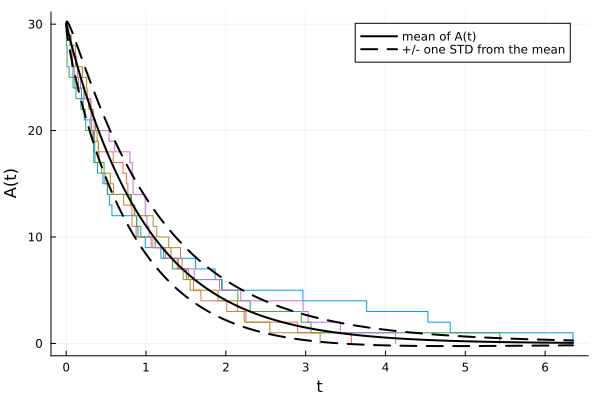

In [21]:
# parameters:
δ          = 1.      # rate of the reaction (units of 1/time)
A₀         = 30      # initial number of molecules
Nsims      = 5       # number of simulations to run
plottraj   = true    # true to plot each trajectory
plotmean   = true    # true to plot the exact mean and +/- one standard deviation


#=
  Simulate trajectories:
  We store each simulation trajectory (A(t) curve) in a vector
  hence trajects[1] would give the vector of A(t) for the first simulation,
  and trajectsT[1] would give the vector of the times reactions occured
  in the first simulation:
=#
trajects  = Vector{Vector{Int}}()      # values of A(t) when a reaction occurs for each simulation
trajectsT = Vector{Vector{Float64}}()  # times reactions occur for each simulation


# if plotting
if plottraj == true
    p = plot()
end

Tmax = 0.   # keep track of the biggest time when we run out of molecules over all simulations

# loop over number of simulations to run
for n = 1:Nsims

    A,T  = generateTraject(A₀, δ)       # run one simulation
    Tmax = max(maximum(T), Tmax)        # calculate new maximum simulation end time
    push!(trajects, A)                  # save values of A(t)
    push!(trajectsT, T)                 # save times of reactions

    if plottraj
        plot!(p, T, A, linetype=:steppost, label="")
    end
end


# deterministic ODE solution = mean number of A at time t =  black curve
# dashed curves give mean +/- one standard deviation from the stochastic simulation
if plotmean && plottraj
    t = (0:1000) / 1000 * Tmax 
    plot!(p, t, A₀ * exp.(-δ*t), linewidth=2, linecolor=:black, label="mean of A(t)", legend=true) 
    plot!(p, t, A₀ * exp.(-δ*t) + sqrt.(A₀ * exp.(-δ*t) .* (1 .- exp.(-δ*t))), linewidth=2, linecolor=:black, linestyle=:dash, label="+/- one STD from the mean")
    plot!(p, t, A₀ * exp.(-δ*t) - sqrt.(A₀ * exp.(-δ*t) .* (1 .- exp.(-δ*t))), linewidth=2, linecolor=:black, linestyle=:dash, label="")
end

if plottraj
    xlabel!(p, "t")
    ylabel!(p, "A(t)")
end


Let's now look at the exact probability that $A(t)=a$ and how it changes over time, given by $p(a,t) = \operatorname{Pr} \left[ A(t) = a \right]$. $p(a,t)$ corresponds to the solution of the chemical master equation we studied in the earlier lecture (where we looked at $I \to \varnothing$), and is given by
\begin{equation*}
p(a,t) = \begin{pmatrix} a_{0} \\ a \end{pmatrix} e^{-\delta a t} \left( 1 - e^{-\delta t} \right)^{a_{0} - a}.
\end{equation*} 

$p(a,t)$ is an example of a binomial distribution, and we can efficiently evaluate it using Julia's `Distributions.jl` package.

We now plot histograms of $p(a,t)$ vs $a$ as $t$ is varied to see how the probability distribution changes over time:

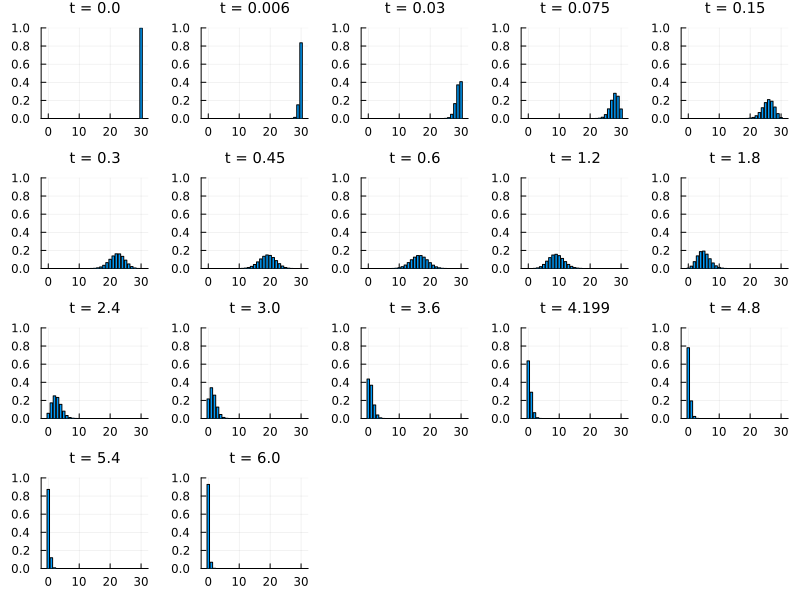

In [22]:
using Distributions
A = 0:A₀
t = [0., 0.001, 0.005, 0.0125, 0.025, 0.05, 0.075, collect(.1:.1:1)...] / (A₀*δ) * 180
p = []
for i = 1:length(t)
    dist = Binomial(A₀, exp(-δ*t[i]))
    push!(p,bar(A, Distributions.pdf.(dist, A), legend=false, ylims=(0,1), titlefontsize=10, title=string("t = ", trunc(t[i],digits=3))))
end
plot(p..., size=(800,600))

## Problem 3
Q: Why do the plots show the pdf shifting from right to left?

A: 


## Problem 4
Now, copy the $\mathrm{A} \to \varnothing$ SSA simulation code from above into the code block below. Run it for `20000` simulations. Then look at the second code block below, and add code to save the first reaction time values from each simulation in one vector. Mimic the histogram code used for plotting the inverse sampling densities above to plot a properly normalized histogram of the first reaction times. If you do this correctly it should follow the curve of the exponential pdf that is also plotted. 

In [10]:
# copy the A -> 0 code here, but set plottraj and plotmean to false
# run the code for 20000 simulations


In [11]:
# MODIFY BELOW 
# calculate the distribution of times of the first reaction. Note,
# trajectsT[n][2] is the time of the first reaction from the n'th simulation
firsttimes = zeros(Nsims)    # vector of first reaction times
 
# lopp over the number of simulations, and save the first reaction time from 
# the i'th simulation in firsttimes[i]
# MODIFY HERE:

# now we plot the exact first reaction time pdf
t   = (0:1000)/1000 * (20.0 / (δ*A₀))
pdf = t -> δ * A₀ * exp(-δ*A₀*t)  
p   = plot(t, pdf.(t), linecolor=:black, linewidth=2, label="exact pdf", xlabel="t")            

# now mimic the code from the inverse sampling plots above to generate a histogram of the times in
# firstTimes (appropriately normalized, using 100 bins)
# on the same plot as the exact pdf from above.
# MODIFY HERE:


UndefVarError: UndefVarError: `plot` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Problem 5
Finally, modify the code below to calculate the mean number of proteins from the simulations at the times in the `t` vector. For `Nsims=10` re-run the stochastic $\mathrm{A} \to \varnothing$ reaction code above. In the code box below, add code to calculate the mean, and plot both it and the true mean, $\left<A(t)\right> = A_0 \exp(-\delta t)$, on the same graph. For reference, if $A_i(t)$ refers to the trajectory of the $i$th simulation, you need to calculate

\begin{equation}
\left<A(t)\right> = \frac{1}{N_{sims}} \sum_{i=1}^{N_{sims}} A_i(t)
\end{equation}

You will need to use the `evaltraject_attimes` function, see below. It takes as input the times of reactions from one simulation, and the values of $\mathrm{A}$ at those times, and then returns the values of $A(t)$ from that simulation at the times in `newtimes`.

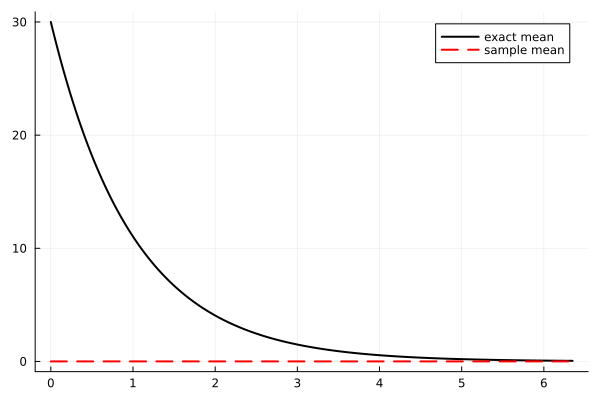

In [23]:
#=
    Given a function that is piecewise constant, and changes 
    values at specified times, evaluate the function at the newTimes.

    Parameters
    ----------
    curtimes: array
             Times that the values of the trajectory change at. Assumes starts at t=0.

    traject: array
             Values of the trajectory after each time change in curtimes. Assumes values >= 0.

    newtimes: array
             Times to evaluate the trajectory at.

    Returns
    -------
    newtraject: array
             Value of the trajectory at the times in newtimes
=#
function evaltraject_attimes(curtimes, traject, newtimes)
    newtraject = zeros( length(newtimes) )
    idx        = 1
    
    for i = 2:length(curtimes)
        
        while newtimes[idx] < curtimes[i]            
            newtraject[idx] = traject[i-1]
            idx = idx + 1
            if idx > length(newtimes)
                return newtraject
            end
        end
    end
    
    # if some of the new times are > the last original time,
    # just take the last value from curTimes
    if idx <= length(newtimes)
        newtraject[idx:end] .= traject[end]
    end
    
    return newtraject
end

# times to plot at
t = (0:1000) / 1000 * Tmax

# array to store the (sample) mean number of A at the times in t
Amean = zeros( length(t) )

# plotting the exact mean
Aode = t -> A₀ * exp(-δ*t)
p = plot(t, Aode.(t), linecolor=:black, label="exact mean", linewidth=2) 
    
# YOU MODIFY HERE
# Pseudocode:
# loop over i = 1, 2, .., Nsims
#   add to Amean the values of trajects[i] evaluated at the 
#   times in t by using the evaltraject_attimes function:

# divide by number of sims to get the mean
Amean .= Amean ./ Nsims
    
# plot the sample mean
plot!(p, t, Amean, linecolor=:red, linewidth=2, linestyle=:dash, label="sample mean")

In [24]:
# print the maximum difference between the mean and the sample mean:
println("max difference is: ", maximum(abs.(Amean .- Aode.(t))))

max difference is: 30.0


Finally, re-run for `Nsims=1000`. If your code is working you should see that the sampled mean and the exact mean match perfectly on the graph, and the max difference between them is relatively small.